In [3]:
import kagglehub
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [7]:
path = "train delay data.csv"
print(path)
print(os.path.exists(path))
print(os.getcwd())

train delay data.csv
True
C:\Users\aadil\Projects\stinger-delay\Analysis
Hello world


In [ ]:
df = pd.read_csv(path)
print('test')
print(df.head())
print(df.info())

   Distance Between Stations (km) Weather Conditions Day of the Week  \
0                             100              Clear          Monday   
1                             150              Rainy         Tuesday   
2                             200              Foggy       Wednesday   
3                              50              Clear        Thursday   
4                              75              Rainy          Friday   

  Time of Day Train Type  Historical Delay (min) Route Congestion  
0     Morning    Express                       5              Low  
1   Afternoon  Superfast                      10           Medium  
2     Evening      Local                      15             High  
3       Night    Express                       2              Low  
4     Morning  Superfast                       8           Medium  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2878 entries, 0 to 2877
Data columns (total 7 columns):
 #   Column                          Non-Null Count  

In [10]:
categorical_columns = df.select_dtypes(include=['object']).columns
print("Categorical columns:", categorical_columns)

# One-hot encode all categorical columns
df = pd.get_dummies(df, columns=categorical_columns)

Categorical columns: Index(['Weather Conditions', 'Day of the Week', 'Time of Day', 'Train Type',
       'Route Congestion'],
      dtype='object')


In [11]:
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df.drop(columns=[]))
df_scaled = pd.DataFrame(df_scaled, columns=df.columns)

In [12]:
# Function to create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length].values)
        y.append(data.iloc[i+seq_length, -1])
    return np.array(X), np.array(y)

SEQ_LENGTH = 10
X, y = create_sequences(df_scaled, SEQ_LENGTH)

In [13]:
# Split into training and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [14]:
# Build LSTM Model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(SEQ_LENGTH, X.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1)  # Output layer
])

model.compile(optimizer='adam', loss='mse')

C:\Users\aadil\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [15]:
# Train model
model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test))

# Evaluate model
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Test RMSE:", rmse)

Epoch 1/60
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.1900 - val_loss: 0.0254
Epoch 2/60
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0590 - val_loss: 0.0350
Epoch 3/60
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0467 - val_loss: 0.0482
Epoch 4/60
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0474 - val_loss: 0.0489
Epoch 5/60
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0410 - val_loss: 0.0528
Epoch 6/60
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0302 - val_loss: 0.0221
Epoch 7/60
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0260 - val_loss: 0.0121
Epoch 8/60
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0244 - val_loss: 0.0184
Epoch 9/60
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0191 - val_loss: 0.0082
Epoch 10/60
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0166 - val_loss: 0.0069
Epoch 11/60
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0151 - val_loss: 0.0104
Epoch 12/60
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0156 - val_l

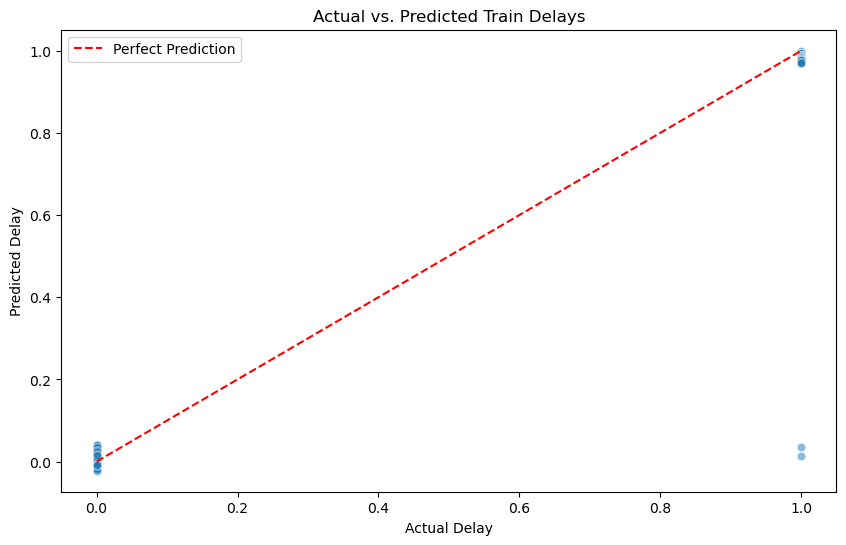

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Convert test predictions back to original scale if normalized
y_test_actual = y_test  # True values
y_pred_actual = y_pred.squeeze()  # Predicted values (remove extra dimension if needed)

# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test_actual, y=y_pred_actual, alpha=0.5)
plt.plot([min(y_test_actual), max(y_test_actual)], [min(y_test_actual), max(y_test_actual)],
         color='red', linestyle='--', label="Perfect Prediction")

# Labels and title
plt.xlabel("Actual Delay")
plt.ylabel("Predicted Delay")
plt.title("Actual vs. Predicted Train Delays")
plt.legend()
plt.show()

In [17]:
from sklearn.metrics import r2_score, mean_absolute_error

r2 = r2_score(y_test_actual, y_pred_actual)
print("Test R-squared:", r2)

mae = mean_absolute_error(y_test_actual, y_pred_actual)
print("Test MAE:", mae)

Test R-squared: 0.9839416838085869
Test MAE: 0.01752637815742854


In [20]:
print(df.columns.tolist())

['Distance Between Stations (km)', 'Historical Delay (min)', 'Weather Conditions_Clear', 'Weather Conditions_Foggy', 'Weather Conditions_Rainy', 'Day of the Week_Friday', 'Day of the Week_Monday', 'Day of the Week_Saturday', 'Day of the Week_Sunday', 'Day of the Week_Thursday', 'Day of the Week_Tuesday', 'Day of the Week_Wednesday', 'Time of Day_Afternoon', 'Time of Day_Evening', 'Time of Day_Morning', 'Time of Day_Night', 'Train Type_Express', 'Train Type_Local', 'Train Type_Superfast', 'Route Congestion_High', 'Route Congestion_Low', 'Route Congestion_Medium']
